# Tomato Disease Detection project 

Dataset Link: https://www.kaggle.com/datasets/kaustubhb999/tomatoleaf/data

# Import Libraries

In [163]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import HTML
from tensorflow.keras import models, layers
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

# Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [152]:
BATCH_SIZE = 64
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=40
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory="tomato",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 11000 files belonging to 10 classes.


In [116]:
class_names = dataset.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [117]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape) # Number of batch images=64, size of image=256*256, RGB channel=3 
    print(labels_batch.numpy()) # Label batches give each class a number from 0:10

(64, 256, 256, 3)
[5 0 3 9 3 7 1 3 4 5 0 3 7 2 5 9 6 0 9 6 0 9 7 7 4 9 5 7 0 1 7 3 6 8 7 7 5
 7 6 9 2 4 5 2 0 4 5 4 2 4 0 2 7 0 1 2 7 5 2 1 3 3 3 5]


# Visualize some of the images from our dataset

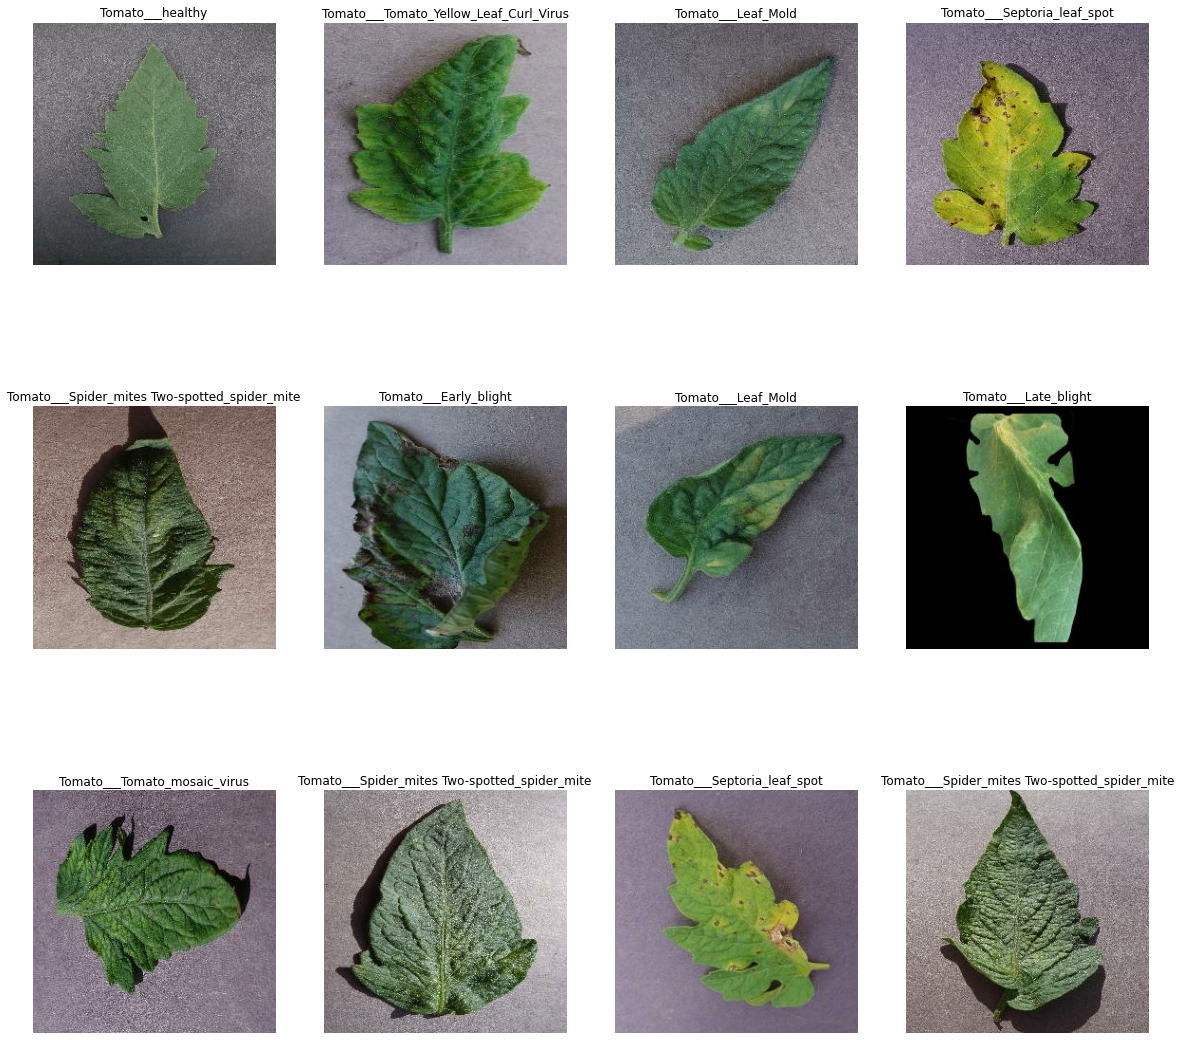

In [118]:
plt.figure(figsize=(20, 20))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [119]:
len(dataset)
# 64 * 172 = 11008 files
# 11000 files

172

# Split the data into train & test & Validation dataset

In [120]:
# by logical viwe spliting
print("len(dataset)", len(dataset), '\n')
train_size = 0.85
train_data = dataset.take(int(len(dataset)*train_size))
print("len(train_data): ", len(train_data), '\n')
test_data = dataset.skip(146)
print("len(test_data)Now before val: ", len(test_data), '\n')
val_size = 0.1
print('len(dataset)*val_size', len(dataset)*val_size, '\n')
val_data = test_data.take(17)
print("len(val_ds)", len(val_data), '\n')
test_data = test_data.skip(17)
print("len(test_data)", len(test_data))

len(dataset) 172 

len(train_data):  146 

len(test_data)Now before val:  26 

len(dataset)*val_size 17.2 

len(val_ds) 17 

len(test_data) 9


In [121]:
# Collect all of them in a function
def split_data(ds, train_split=0.85, val_split=0.10, test_split=0.05, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12) # seed to give you different results(Improve ability to predict)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [122]:
train_data, val_data, test_data = split_data(dataset)

In [123]:
print("len(train_data):", len(train_data))
print("len(val_data):  ", len(val_data))
print("len(test_data): ", len(test_data))

len(train_data): 146
len(val_data):   17
len(test_data):  9


# Cache, Shuffle, and Prefetch the Dataset to make training run fast

In [125]:
# Cash ==> keep image in the RAM so it will be more fast for the model
# prefatch ==> if GPU are bussy he will load another batch using CPU to be ready for the GPU procrssing and Reverse is True
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Preprocessing the images dataset

we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256

You might be thinking why do we need to resize (256,256) image to again (256,256), this will be useful when we make predictions

In [126]:
# it is an layer i will use it for any image for prediction
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Data Augmentation

In [127]:
# it create new samples for training data to avoid the overfit, improve accurcy
# like Create from the original data ==> contrast(التباين), Rotation, flip, and zoom the images
# here i make only flip and rotation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.3),
])

Apply Data Augmentation on training dataset

In [128]:
train_data = train_data.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# CNN Model Architecture

In [129]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [130]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (64, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (64, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (64, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (64, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (64, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (64, 60, 60, 64)         

In [131]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [132]:
history = model.fit(
    train_data,
    batch_size=BATCH_SIZE,
    validation_data=val_data,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/40
146/146 [==============================] - 1287s 7s/step - loss: 1.8799 - accuracy: 0.2822 - val_loss: 1.5770 - val_accuracy: 0.4173
Epoch 2/40
146/146 [==============================] - 697s 5s/step - loss: 1.1146 - accuracy: 0.6018 - val_loss: 2.6035 - val_accuracy: 0.3906
Epoch 3/40
146/146 [==============================] - 809s 5s/step - loss: 0.8195 - accuracy: 0.7090 - val_loss: 1.4334 - val_accuracy: 0.5763
Epoch 4/40
146/146 [==============================] - 739s 5s/step - loss: 0.6658 - accuracy: 0.7648 - val_loss: 1.5504 - val_accuracy: 0.5699
Epoch 5/40
146/146 [==============================] - 1279s 9s/step - loss: 0.5839 - accuracy: 0.7915 - val_loss: 1.7295 - val_accuracy: 0.5864
Epoch 6/40
146/146 [==============================] - 908s 6s/step - loss: 0.5322 - accuracy: 0.8132 - val_loss: 1.3645 - val_accuracy: 0.6241
Epoch 7/40
146/146 [==============================] - 1050s 7s/step - loss: 0.4699 - accuracy: 0.8375 - val_loss: 0.9542 - val_accuracy: 0.6

In [133]:
scores = model.evaluate(test_data)

9/9 [==============================] - 1249s 11s/step - loss: 0.4169 - accuracy: 0.8906


In [134]:
scores

[0.41694167256355286, 0.890625]

In [135]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [136]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 146}

In [137]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [138]:
type(history.history['loss'])

list

In [139]:
len(history.history['loss'])

40

In [140]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.8799060583114624,
 1.1145691871643066,
 0.8194606304168701,
 0.6658284664154053,
 0.5838719010353088]

In [141]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot Training and Validation Accuracy&Training and Validation Loss 

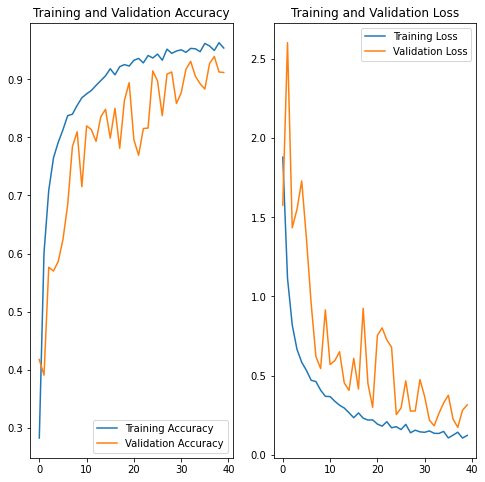

In [153]:
# Training and Validation Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Run prediction on a sample image

first image to predict
actual label: Tomato___Late_blight
2/2 [==============================] - 19s 528ms/step
predicted label: Tomato___Late_blight


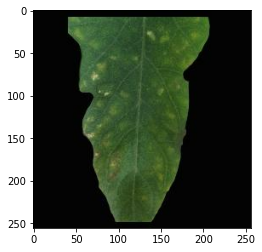

In [143]:
import numpy as np
for images_batch, labels_batch in test_data.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Write that in a function for inference

In [144]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Now run inference on few sample images

1/1 [==============================] - 0s 39ms/step


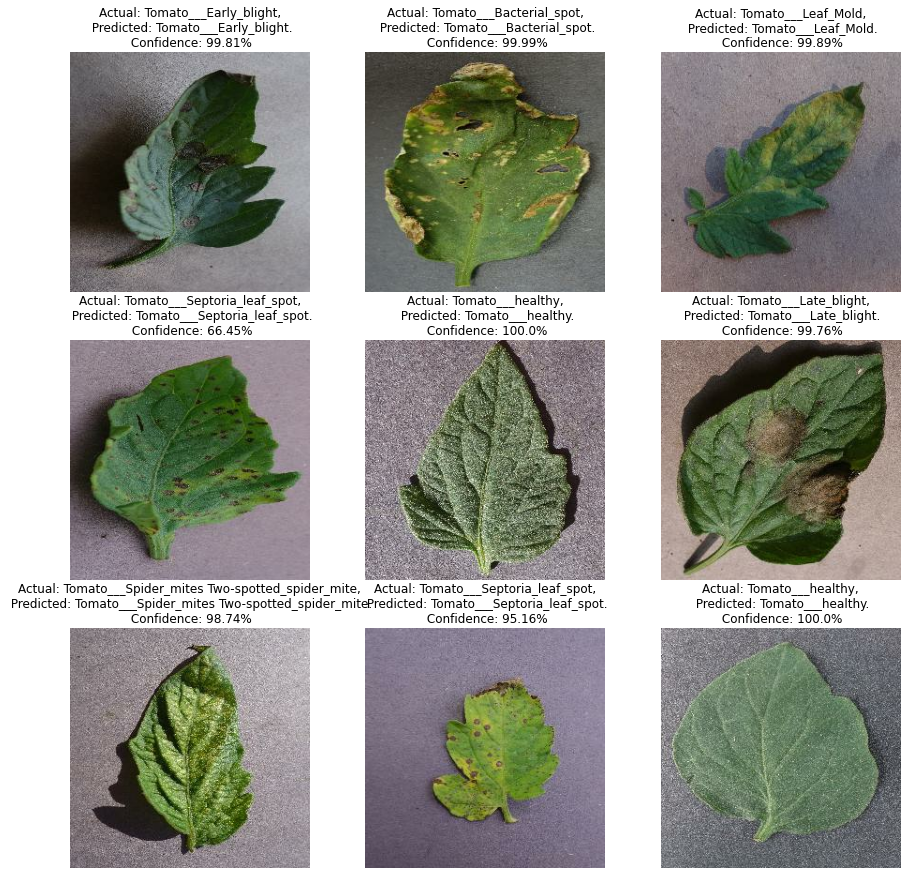

In [159]:
plt.figure(figsize=(15, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving the Model

In [161]:
import os
model_version=max([int(i) for i in os.listdir("../model") + [0]])+1
model.save(f"../model/{model_version}")

INFO:tensorflow:Assets written to: ../model/3\assets


INFO:tensorflow:Assets written to: ../model/3\assets


In [162]:
model.save("../tomato.h9")

INFO:tensorflow:Assets written to: ../tomato.h9\assets


INFO:tensorflow:Assets written to: ../tomato.h9\assets


# Start deployment using Fast API & tf serving 